# Doppler (Interferometry) Radar

<a href="https://rookiepeng.github.io/radarsimpy/" target="_blank" rel="nofollow"><img src="https://img.shields.io/badge/Documentation-latest-brightgree?style=flat&logo=read-the-docs" height="20" align="left"></a>

<br></br>
This is a Doppler (interferometry) radar simulation example based on [`RadarSimPy`](https://github.com/rookiepeng/radarsimpy).

---


## Radar Model
### Transmitter

Setup the basic transmitter parameters through `Transmitter` module.

The following table lists the parameters in this example.

| Parameter                       | Variable in `Transmitter`| Value      |
|---------------------------------|--------------------------|------------|
| Center frequency ($f_c$)        | `f`                      | 24.125 GHz |
| Signal length ($T$)             | `t`                      | 20 s       |
| Transmitted power ($P_t$)       | `tx_power`               | 10 dBm     |

A single transmitter channel is used in this example. The tranmitter channel is located at [0, 0, 0].

### Receiver

Setup the receiver parameters through `Receiver` module.

The parameters of the receiver are listed in the table below.

| Parameter                        | Variable in `Receiver`   | Value        |
|----------------------------------|--------------------------|--------------|
| Sampling rate ($f_s$)            | `fs`                     | 20 sps       |
| Noise figure ($NF$)              | `noise_figure`           | 12 dB        |
| RF gain/loss ($G_{rf}$)          | `rf_gain`                | 20 dB        |
| Baseband gain ($G_{BB}$)         | `baseband_gain`          | 50 dB        |
| Load resistor ($R_L$)            | `load_resistor`          | 1000 $\Omega$|

A single receiver channel is used in this example. The receiver channel is located at [0, 0, 0].

In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

# setup transmitter
tx = Transmitter(f=24.125e9,
                 t=20,
                 tx_power=10,
                 pulses=1,
                 channels=[dict(location=(0, 0, 0))])

# setup receiver
rx = Receiver(fs=20,
              noise_figure=12,
              rf_gain=20,
              baseband_gain=50,
              load_resistor=1000,
              channels=[dict(location=(0, 0, 0))])

# create radar
radar = Radar(transmitter=tx, receiver=rx)

### Targets

Define a list of targets. There is only one target in this simulaiton. The motion of the target is defined by:

`1.4+1e-3*np.sin(2*np.pi*1*radar.timestamp)`

`radar.timestamp` is the time matrix of the baseband samples.

In [2]:
target = dict(location=(1.4+1e-3*np.sin(2*np.pi*1*radar.timestamp), 0, 0),
              rcs=-10,
              phase=0)

targets = [target]

## Simulate Baseband Signals

Use the `simulator` module to simulate the baseband samples. The user can choose between Python engine `simpy` or C++ engine `simc`.

The output baseband data is a 3-D matrix:

$[channels, pulses, ADC~samples]$

In [3]:
# Python engine
from radarsimpy.simulator import simpy
# C++ engine
from radarsimpy.simulator import simc

bb_data = simc(radar, targets)
timestamp = bb_data['timestamp']
baseband = bb_data['baseband']

Plot the baseband

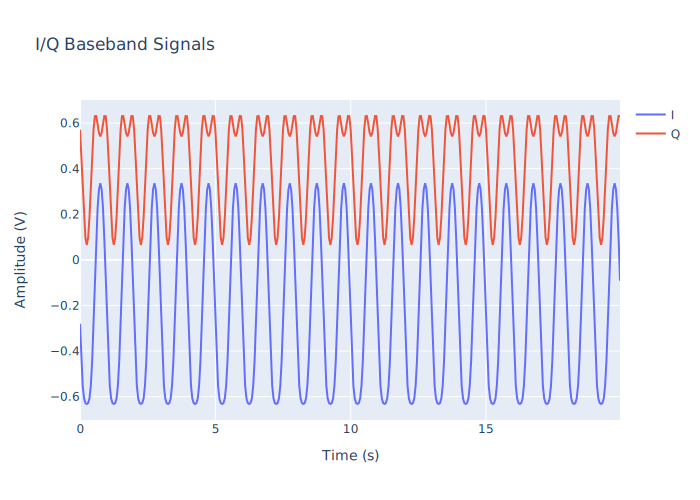

In [4]:
import plotly.graph_objs as go
from IPython.display import SVG, display

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.real(baseband[0, 0, :]),
    name='I',
))
fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.imag(baseband[0, 0, :]),
    name='Q',
))

fig.update_layout(
    title='I/Q Baseband Signals',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))

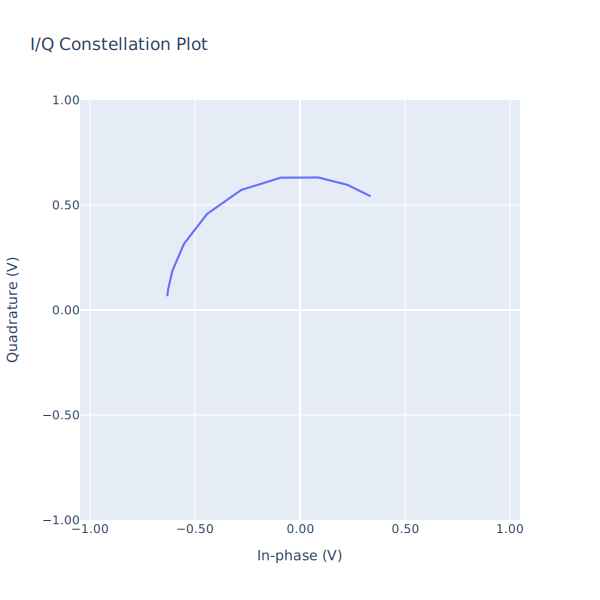

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.real(baseband[0, 0, :]),
    y=np.imag(baseband[0, 0, :]),
))

fig.update_layout(
    title='I/Q Constellation Plot',
    xaxis=dict(range=[-1, 1], tickformat='.2f', title='In-phase (V)'),
    yaxis=dict(range=[-1, 1],
               tickformat='.2f',
               title='Quadrature (V)',
               scaleanchor="x",
               scaleratio=1),
    height=600,
    width=600,
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))

## Phase demodulation

Demodulate the phase of the baseband signal

In [6]:
demod = np.angle(baseband[0, 0, :])

Plot

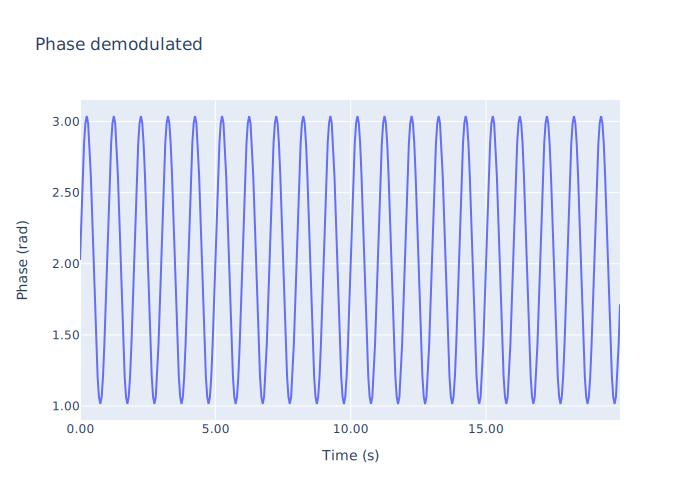

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=demod,
))

fig.update_layout(
    title='Phase demodulated',
    xaxis=dict(tickformat='.2f', title='Time (s)'),
    yaxis=dict(tickformat='.2f', title='Phase (rad)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))